# Data Preparation

In [776]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# setting display format so that large values are shown properly
pd.set_option('display.float_format', lambda x: '%.4f' % x)

sns.set_style(style='dark')
sns.set_context("notebook")

In [777]:
housing = pd.read_csv('train.csv')

In [778]:
housing.shape

(1460, 81)

In [779]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [780]:
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [781]:
housing.index = housing['Id']

housing = housing.drop('Id',axis=1)

In [782]:
def get_columns_with_nan_percentage(df):
    nan_cols = [{
            "column":c,
            "percentage":round(100*(df[c].isnull().sum()/len(df[c].index)), 2),
            "type":df[c].dtype
            } for c in df.columns if round(100*(df[c].isnull().sum()/len(df[c].index)), 2)>0]
    return pd.DataFrame.from_records(nan_cols)

In [783]:
get_columns_with_nan_percentage(housing)

,column,percentage,type
0,LotFrontage,17.7400,float64
1,Alley,93.7700,object
2,MasVnrType,0.5500,object
3,MasVnrArea,0.5500,float64
4,BsmtQual,2.5300,object
5,BsmtCond,2.5300,object
6,BsmtExposure,2.6000,object
7,BsmtFinType1,2.5300,object
8,BsmtFinType2,2.6000,object
9,Electrical,0.0700,object


#### We have so many column which have `NAN` but they are `NA` which are valid values.
Following columns have valid `NA`

1. Alley
2. MasVnrType
3. BsmtQual
4. BsmtCond
5. BsmtExposure
6. BsmtFinType1
7. BsmtFinType2
8. FireplaceQu
9. GarageType
10. GarageFinish
11. GarageQual
12. GarageCond
13. PoolQC
14. Fence
15. MiscFeature

In [784]:
def set_valid_na(columns, df):
    for column in columns:
        df[column].fillna('No_' + column, inplace=True)

In [785]:
set_valid_na([
    'Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
    'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
    'MiscFeature'
],housing)

In [786]:
get_columns_with_nan_percentage(housing)

,column,percentage,type
0,LotFrontage,17.7400,float64
1,MasVnrArea,0.5500,float64
2,Electrical,0.0700,object
3,GarageYrBlt,5.5500,float64


Deleting rows where `MasVnrArea` and `Electrical` is `NAN`

In [787]:
housing = housing[~housing['MasVnrArea'].isnull()]
housing = housing[~housing['Electrical'].isnull()]

In [788]:
get_columns_with_nan_percentage(housing)

,column,percentage,type
0,LotFrontage,17.7100,float64
1,GarageYrBlt,5.5800,float64


Let us analyze `LotFrontage`

In [789]:
housing['LotFrontage'].describe()

count   1194.0000
mean      70.0276
std       24.2993
min       21.0000
25%       59.0000
50%       69.0000
75%       80.0000
max      313.0000
Name: LotFrontage, dtype: float64

Updating `LotFrontage` with mean of the data

In [790]:
housing['LotFrontage'].fillna((housing['LotFrontage'].mean()), inplace=True)

In [791]:
get_columns_with_nan_percentage(housing)

,column,percentage,type
0,GarageYrBlt,5.5800,float64


Updating `GarageYrBlt` with median year for the area.

In [792]:
housing['GarageYrBlt'].fillna((housing['GarageYrBlt'].median()), inplace=True)

In [793]:
get_columns_with_nan_percentage(housing)

""


Now, we can see that there is no NAN in the dataset

There are some columns which are numeric but according to the data dictionary they are categorical. We can convert these columns as categorical.

In [794]:
housing.select_dtypes(include=['float64','int64']).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Following columns can be converted to categorical.

1. MSSubClass
2. OverallQual
3. OverallCond
4. BsmtFullBath
5. BsmtHalfBath
6. FullBath
7. HalfBath
8. BedroomAbvGr
9. KitchenAbvGr
10. TotRmsAbvGrd
11. Fireplaces
12. GarageCars
13. MoSold
14. YrSold
15. GarageYrBlt
16. YearBuilt
17. YearRemodAdd

In [795]:
def convert_to_category(columns):
    for column in columns:
        housing[column] = housing[column].astype('object')

In [796]:
convert_to_category([
    'MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath',
    'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
    'Fireplaces', 'GarageCars', 'MoSold', 'YrSold', 'GarageYrBlt', 'YearBuilt',
    'YearRemodAdd'
])

In [797]:
def get_int_float_columns_with_Zero_percentage(df):
    nan_cols = [{
            "column":c,
            "percentage":round(100*((df[c]==0).sum()/len(df[c].index)), 2),
            "type":df[c].dtype
            } for c in df.columns if round(100*((df[c]==0).sum().sum()/len(df[c].index)), 2)>0]
    return pd.DataFrame.from_records(nan_cols)

In [798]:
get_int_float_columns_with_Zero_percentage(housing.select_dtypes(include=['float64','int64']))

,column,percentage,type
0,MasVnrArea,59.2700,float64
1,BsmtFinSF1,31.9800,int64
2,BsmtFinSF2,88.4900,int64
3,BsmtUnfSF,8.1300,int64
4,TotalBsmtSF,2.5500,int64
5,2ndFlrSF,56.7900,int64
6,LowQualFinSF,98.2100,int64
7,GarageArea,5.5800,int64
8,WoodDeckSF,52.0300,int64
9,OpenPorchSF,45.0000,int64


We can delete the columns which have more 80% **0** values as shown above.

In [799]:
housing = housing.drop([
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
    'PoolArea', 'MiscVal'
],
                       axis=1)

## Analysis of the data

Reference for the following methods: https://towardsdatascience.com/a-starter-pack-to-exploratory-data-analysis-with-python-pandas-seaborn-and-scikit-learn-a77889485baf#89dd and the previous assignments.

In [800]:
default_figsize = (10, 5)

In [801]:
def categorical_summarized(dataframe,
                           x=None,
                           y=None,
                           hue=None,
                           palette='Set1',
                           verbose=True,
                           figsize=default_figsize,
                           title="",
                           xlabel=None,
                           ylabel=None,
                           rotate_labels=False):
    '''
    Helper function that gives a quick summary of a given column of categorical data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data, y would be the count
    y: str. vertical axis to plot the labels of categorical data, x would be the count
    hue: str. if you want to compare it another variable (usually the target variable)
    palette: array-like. Colour of the plot
    Returns
    =======
    Quick Stats of the data and also the count plot
    '''
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]

    if verbose:
        print(series.describe())
        print('mode: ', series.mode())
        print('=' * 80)
        print(series.value_counts())

    sns.set(rc={'figure.figsize': figsize})
    sorted_df = dataframe.sort_values(column_interested)
    ax = sns.countplot(x=x, y=y, hue=hue, data=sorted_df)

    plt.title(title)
    if not xlabel:
        xlabel = column_interested
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    total = len(dataframe[column_interested])
    if rotate_labels:
        plt.setp(ax.get_xticklabels(),
                 rotation=30,
                 horizontalalignment='right')
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height() / 2
        ax.annotate(percentage, (x, y))
    plt.tight_layout()
    plt.style.use('fivethirtyeight')
    plt.show()

In [802]:
def quantitative_summarized(dataframe,
                            x=None,
                            y=None,
                            hue=None,
                            palette='Set1',
                            ax=None,
                            verbose=True,
                            swarm=False,
                            figsize=default_figsize):
    '''
    Helper function that gives a quick summary of quantattive data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlayed
    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    '''
    series = dataframe[y]
    print(series.describe())
    if verbose:
        print('mode: ', series.mode())
        print('=' * 80)
        print(series.value_counts())
    sns.set(rc={'figure.figsize': figsize})

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe, palette=palette, ax=ax)

    if swarm:
        sns.swarmplot(x=x,
                      y=y,
                      hue=hue,
                      data=dataframe,
                      palette=palette,
                      ax=ax)
    plt.tight_layout()
    plt.style.use('fivethirtyeight')
    plt.show()

In [803]:
def plot_column(df,
                col,
                chart_type='Hist',
                dtype=int,
                bins=25,
                figsize=default_figsize):
    temp_df = df[col]
    sns.set(rc={'figure.figsize': figsize})
    if chart_type == 'Hist':
        ax = sns.countplot(temp_df)
    elif chart_type == 'Dens':
        ax = sns.distplot(temp_df)
    xmin, xmax = ax.get_xlim()
    ax.set_xticks(np.round(np.linspace(xmin, xmax, bins), 2))
    plt.tight_layout()
    plt.locator_params(axis='y', nbins=6)
    plt.style.use('fivethirtyeight')
    plt.show()

In [804]:
def univariate_analysis(col,
                        chart_type='Dens',
                        df=housing,
                        is_categorical=False,
                        title="",
                        xlabel=None,
                        ylabel=None,
                        rotate_labels=False,
                        bins=25):
    if is_categorical:
        categorical_summarized(df,
                               x=col,
                               title=title,
                               xlabel=xlabel,
                               ylabel=ylabel,
                               rotate_labels=rotate_labels,
                               verbose=False)
    else:
        quantitative_summarized(df, y=col, verbose=False)
        plot_column(df, col, chart_type=chart_type, bins=bins)


### *SalePrice* is the dependent variable, so let us start with the analysis of SalePrice


count     1451.0000
mean    180624.1020
std      79312.1283
min      34900.0000
25%     129900.0000
50%     162500.0000
75%     214000.0000
max     755000.0000
Name: SalePrice, dtype: float64


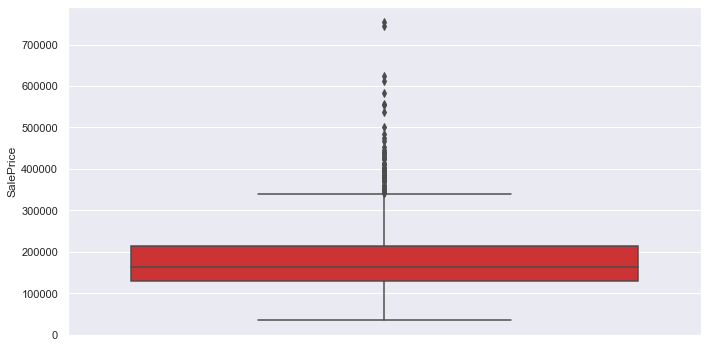

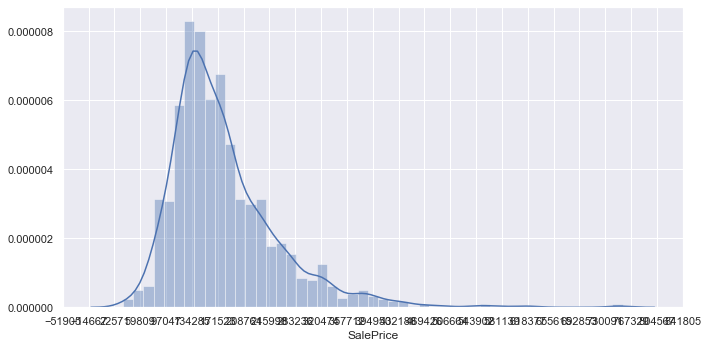

In [805]:
univariate_analysis('SalePrice')

As we can see that the price is skewed and is not normally distributed. We can use log transform and see the behavior.

In [806]:
housing['NormalSalePrice'] = np.log(housing["SalePrice"])

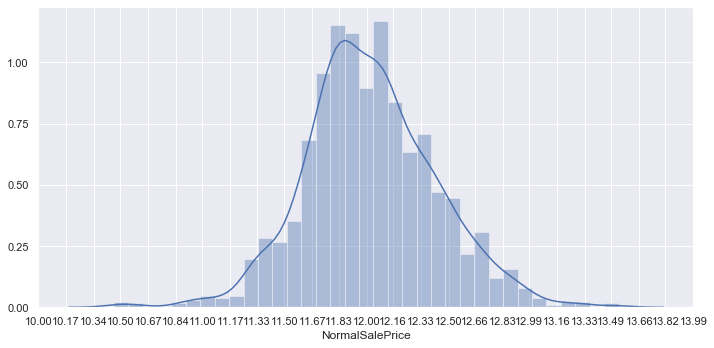

In [807]:
plot_column(housing, 'NormalSalePrice', chart_type='Dens', bins=25)

#### As we can see that, the log transformed price is normally distributed, thus we will use this column moving forward for the model creation.

In [808]:
# Dropping `SalePrice` column
housing = housing.drop('SalePrice', axis=1)

Now, we will try to find all the columns which have almost similar values. Here, I am considering columns which have 90% same value.

In [809]:
x=.90
columns_to_delete=[]
for c in housing.columns:
    if(any(y > x for y in housing[c].value_counts(dropna=False, normalize=True).tolist())):
        columns_to_delete.append(c)
columns_to_delete

['Street',
 'Alley',
 'Utilities',
 'LandSlope',
 'Condition2',
 'RoofMatl',
 'Heating',
 'CentralAir',
 'Electrical',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'Functional',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'MiscFeature']

We can delete the above columns as they are skewed.

In [810]:
housing = housing.drop(columns_to_delete, axis=1)

In [811]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 1 to 1460
Data columns (total 57 columns):
MSSubClass         1451 non-null object
MSZoning           1451 non-null object
LotFrontage        1451 non-null float64
LotArea            1451 non-null int64
LotShape           1451 non-null object
LandContour        1451 non-null object
LotConfig          1451 non-null object
Neighborhood       1451 non-null object
Condition1         1451 non-null object
BldgType           1451 non-null object
HouseStyle         1451 non-null object
OverallQual        1451 non-null object
OverallCond        1451 non-null object
YearBuilt          1451 non-null object
YearRemodAdd       1451 non-null object
RoofStyle          1451 non-null object
Exterior1st        1451 non-null object
Exterior2nd        1451 non-null object
MasVnrType         1451 non-null object
MasVnrArea         1451 non-null float64
ExterQual          1451 non-null object
ExterCond          1451 non-null object
Foundation  

#### `MoSold`, `YrSold`, `YearRemodAdd` and `GarageYrBlt` will not have impact on the sale price of the property. We will consider `YearBuilt` to calculate the age of the property.

### Adding new column age for the property

In [812]:
# Dropping MoSold, YrSold, YearRemodAdd and GarageYrBlt

housing = housing.drop(['MoSold', 'YrSold', 'YearRemodAdd', 'GarageYrBlt'],
                       axis=1)

housing['Age'] = housing['YearBuilt'].apply(lambda x: 2020 - x).astype(int)
housing = housing.drop('YearBuilt', axis=1)

### Defining variables

## Categorical Variables

    'MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageQual', 'Fence', 'SaleType',
       'SaleCondition'

## Continuous Variables

    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'NormalSalePrice', 'Age'

# Analyzing categorical variables 

In [813]:
def bivariate_analysis(col, df=housing, is_categorical=True):
    univariate_analysis(col, is_categorical=is_categorical)
    quantitative_summarized(dataframe=housing,
                            y='NormalSalePrice',
                            x=col,
                            swarm=True,
                            verbose=False)

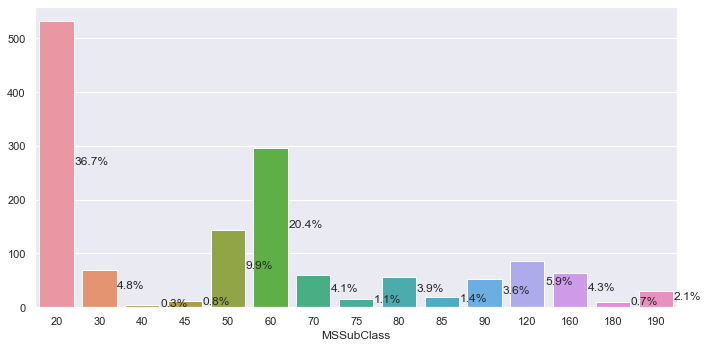

count   1451.0000
mean      12.0224
std        0.3995
min       10.4602
25%       11.7745
50%       11.9984
75%       12.2737
max       13.5345
Name: NormalSalePrice, dtype: float64


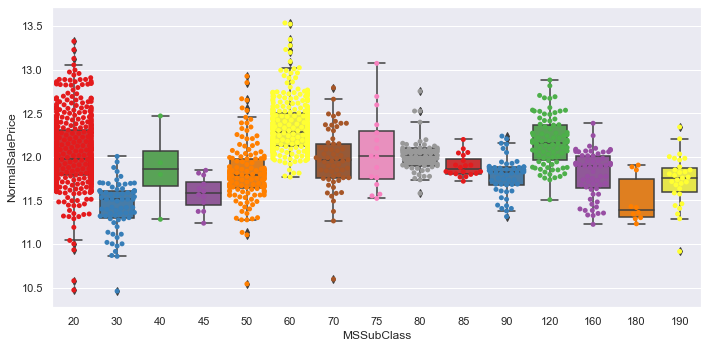

In [814]:
bivariate_analysis('MSSubClass')

We can see that most of the properties belong to MSSubClass 20. However, properties belonging to class 60 are in general more costly.

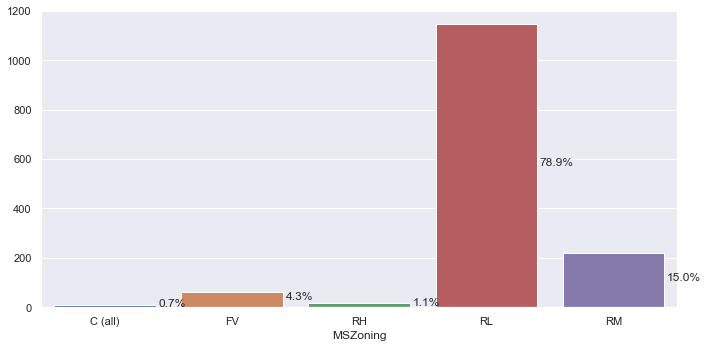

count   1451.0000
mean      12.0224
std        0.3995
min       10.4602
25%       11.7745
50%       11.9984
75%       12.2737
max       13.5345
Name: NormalSalePrice, dtype: float64


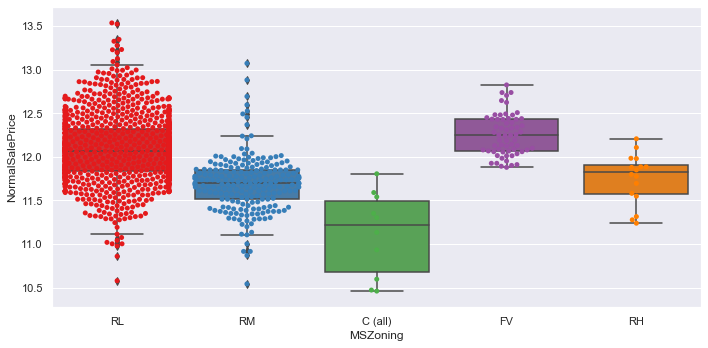

In [815]:
bivariate_analysis('MSZoning')

We can see most of the properties belong to `RL` MSZone with wide range of pricing.

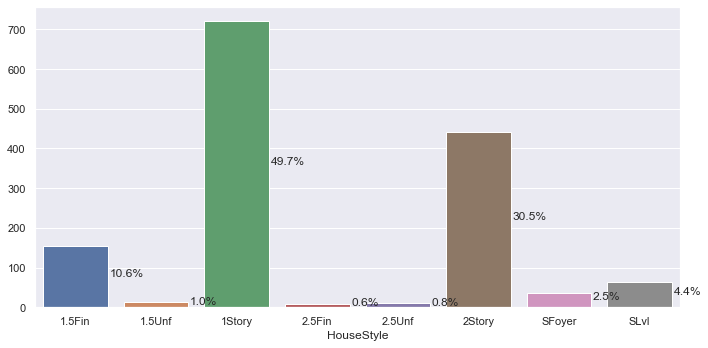

count   1451.0000
mean      12.0224
std        0.3995
min       10.4602
25%       11.7745
50%       11.9984
75%       12.2737
max       13.5345
Name: NormalSalePrice, dtype: float64


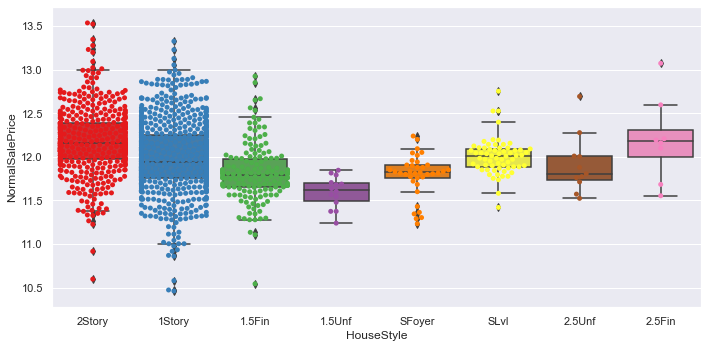

In [816]:
bivariate_analysis('HouseStyle')

1Story properties are the most sold ones and also has range in the price.

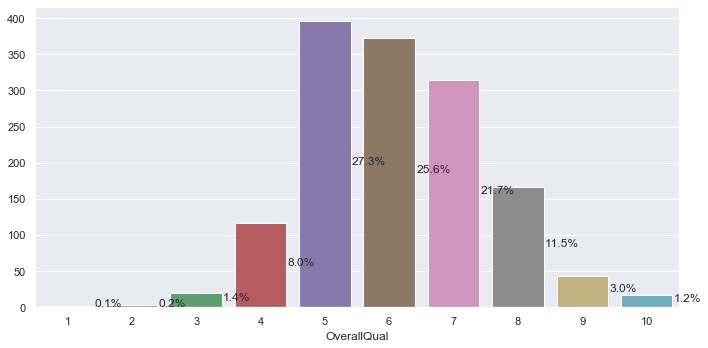

count   1451.0000
mean      12.0224
std        0.3995
min       10.4602
25%       11.7745
50%       11.9984
75%       12.2737
max       13.5345
Name: NormalSalePrice, dtype: float64


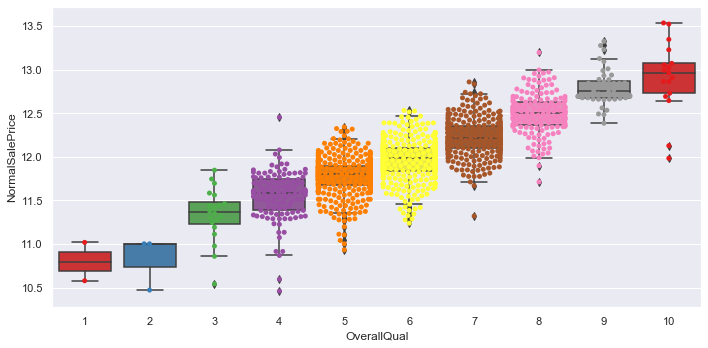

In [817]:
bivariate_analysis('OverallQual')

The most sold properties belong to **5** and **6**. We can see as the over all quality increases the price also increases.

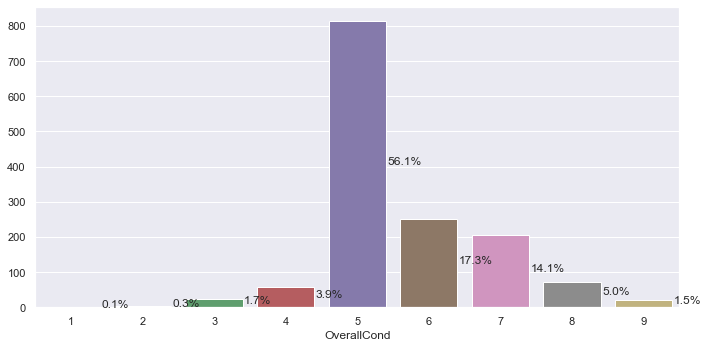

count   1451.0000
mean      12.0224
std        0.3995
min       10.4602
25%       11.7745
50%       11.9984
75%       12.2737
max       13.5345
Name: NormalSalePrice, dtype: float64


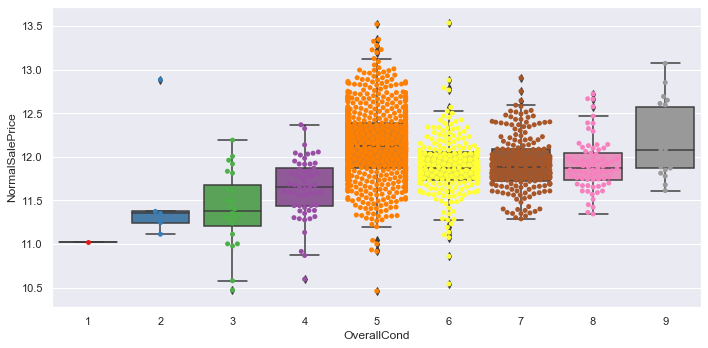

In [818]:
bivariate_analysis('OverallCond')

The most sold properties belong to 5 and 6 and as the overall condition increases the price is also increasing.

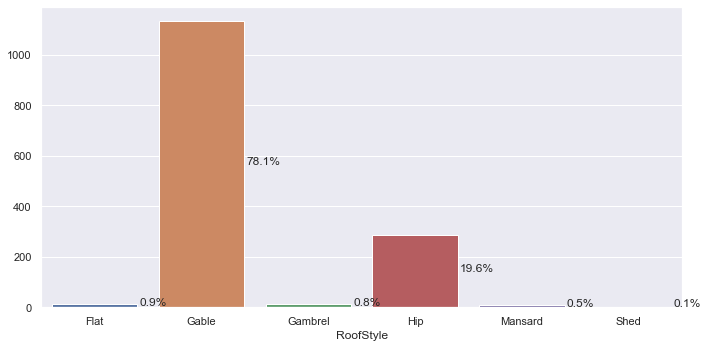

count   1451.0000
mean      12.0224
std        0.3995
min       10.4602
25%       11.7745
50%       11.9984
75%       12.2737
max       13.5345
Name: NormalSalePrice, dtype: float64


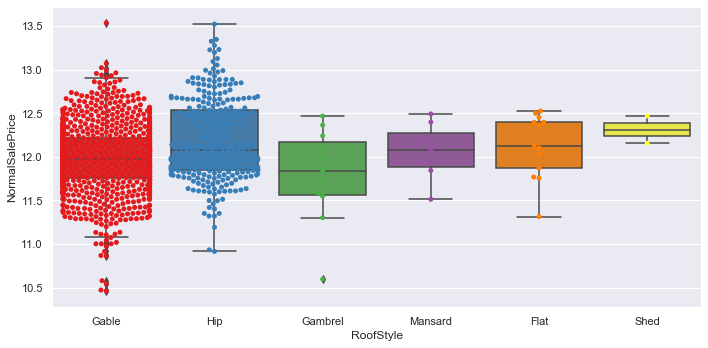

In [819]:
bivariate_analysis('RoofStyle')

Gable roof type properties are the most sold ones. However, **shed** type properties have less variation is price.

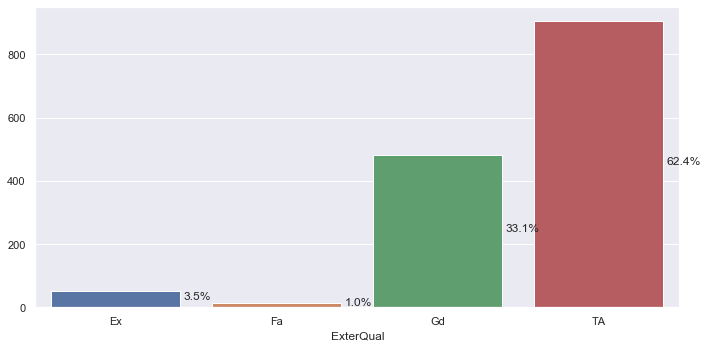

count   1451.0000
mean      12.0224
std        0.3995
min       10.4602
25%       11.7745
50%       11.9984
75%       12.2737
max       13.5345
Name: NormalSalePrice, dtype: float64


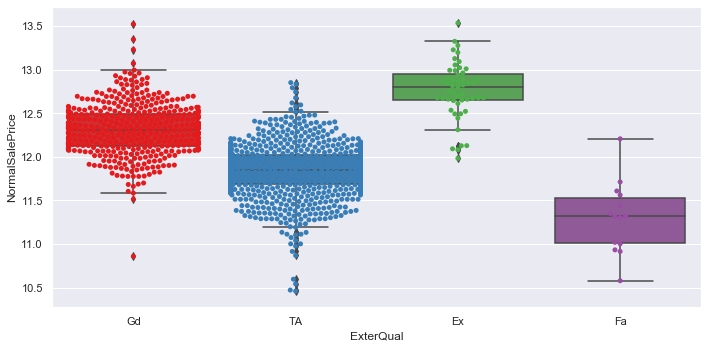

In [820]:
bivariate_analysis('ExterQual')

Most of the sold properties belong to TA

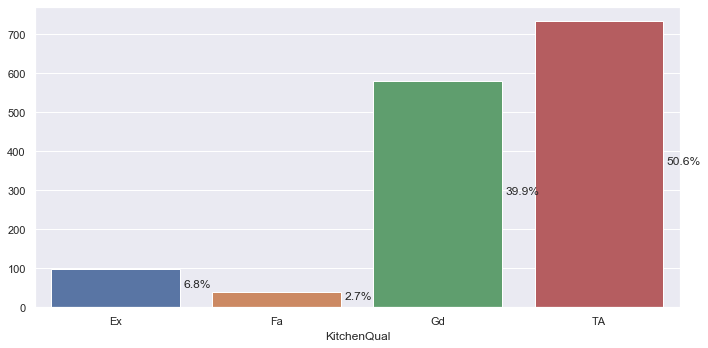

count   1451.0000
mean      12.0224
std        0.3995
min       10.4602
25%       11.7745
50%       11.9984
75%       12.2737
max       13.5345
Name: NormalSalePrice, dtype: float64


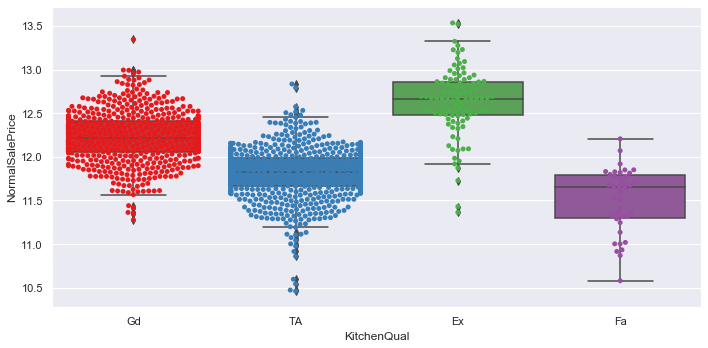

In [821]:
bivariate_analysis('KitchenQual')

Most of the properties have average kitchen type.

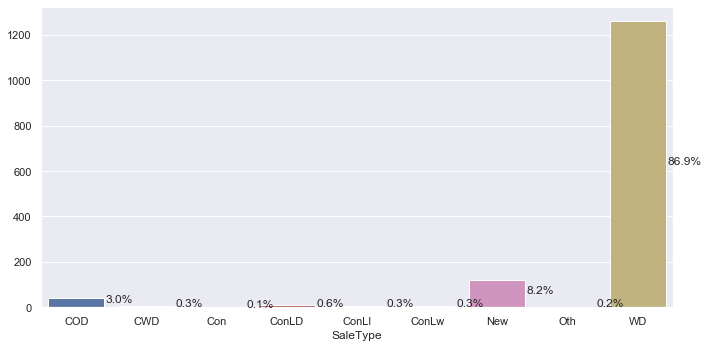

count   1451.0000
mean      12.0224
std        0.3995
min       10.4602
25%       11.7745
50%       11.9984
75%       12.2737
max       13.5345
Name: NormalSalePrice, dtype: float64


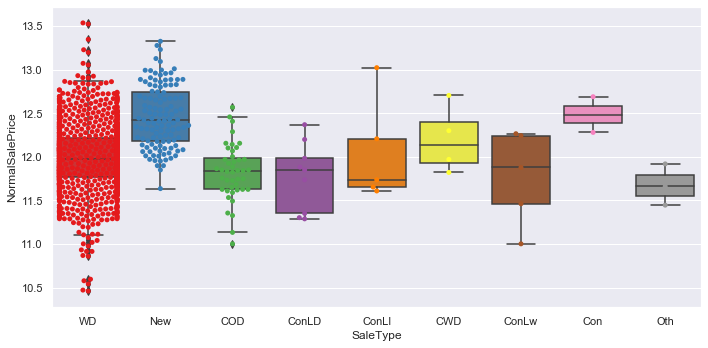

In [822]:
bivariate_analysis('SaleType')

Most of the sales are warrantee deeds and they vary in price too.

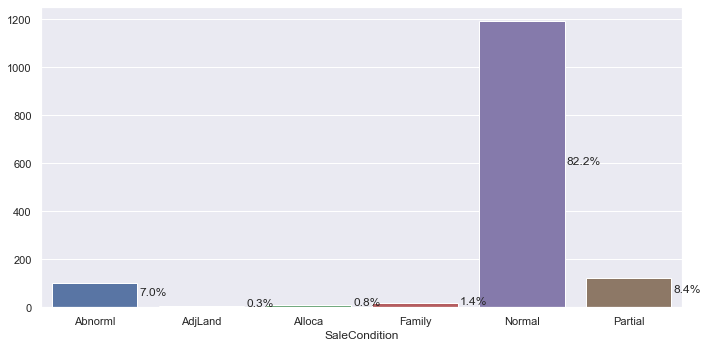

count   1451.0000
mean      12.0224
std        0.3995
min       10.4602
25%       11.7745
50%       11.9984
75%       12.2737
max       13.5345
Name: NormalSalePrice, dtype: float64


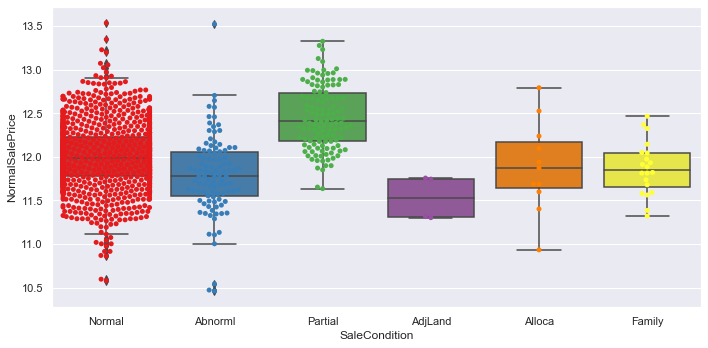

In [823]:
bivariate_analysis('SaleCondition')

## Analyzing continuous variables

In [824]:
housing_num = housing.select_dtypes(include=['float64','int64'])
num_vars = housing_num.columns

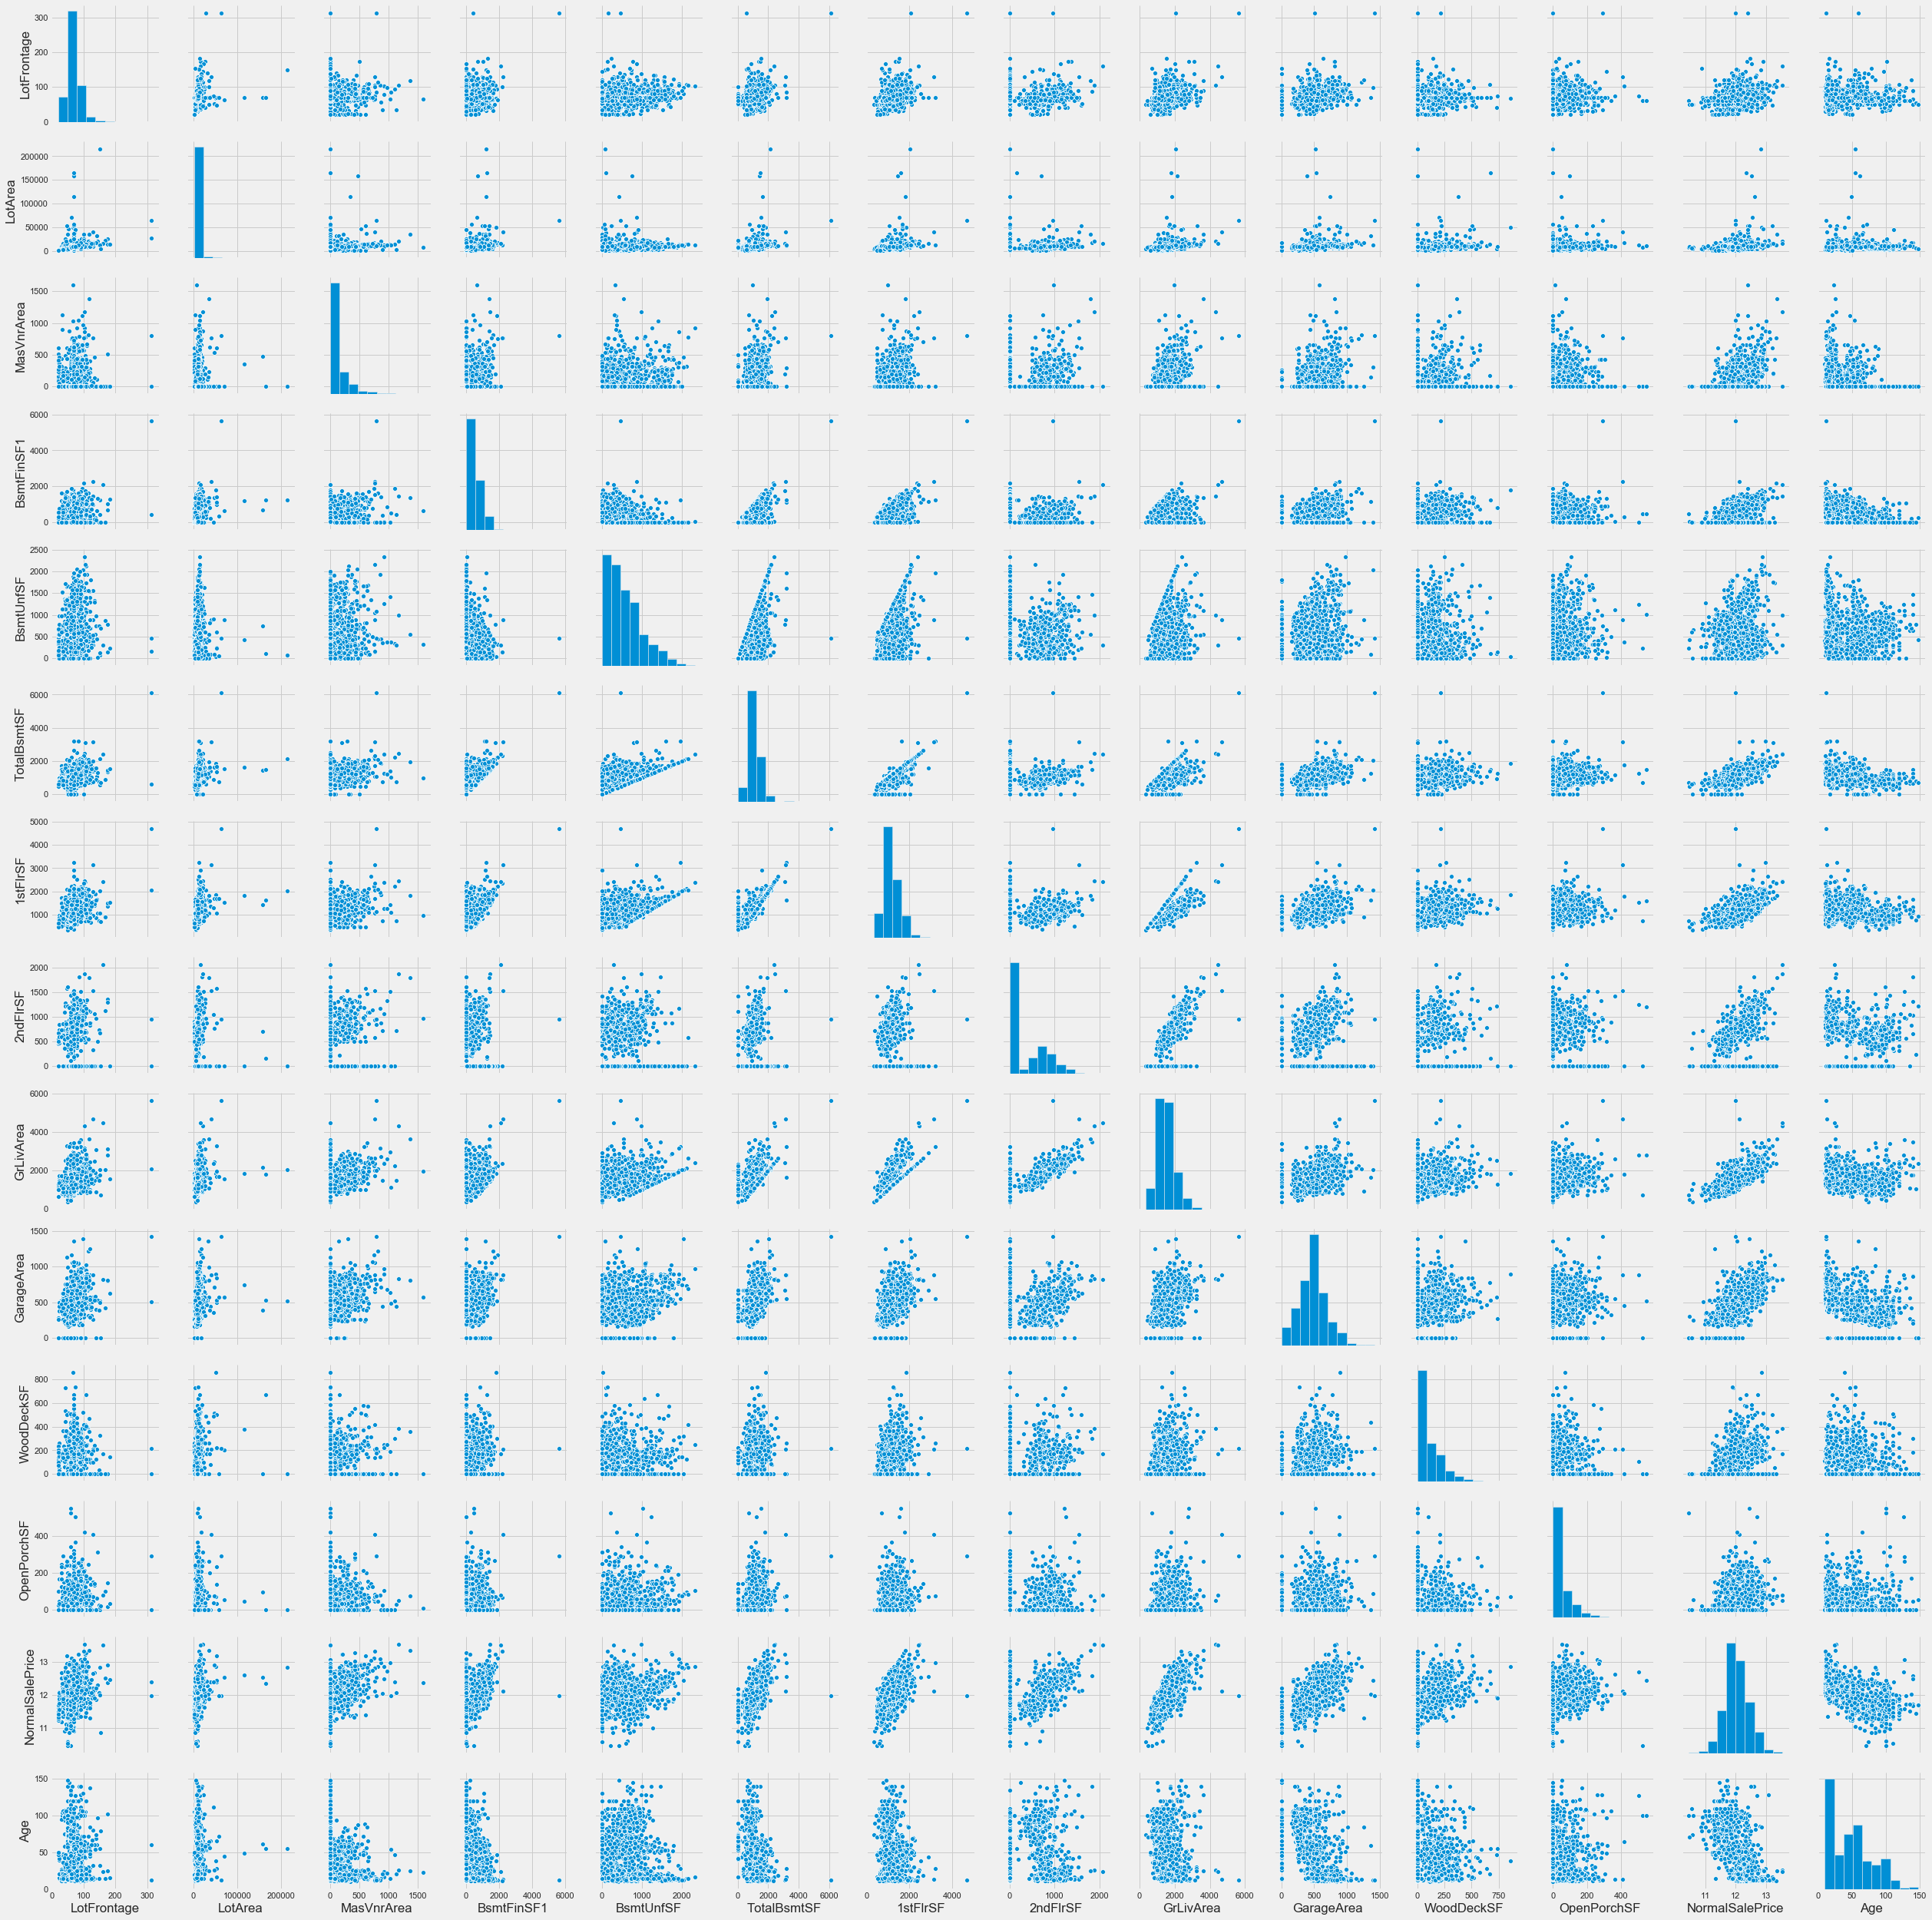

In [825]:
sns.pairplot(housing_num)

We can see outliers in some of the charts against NormalSalesPrice. We will use IQR to identify and remove outliers

## Removing outliers

In [826]:
def get_lower_upper_bound(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)

    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 2.5)
    return lower_bound, upper_bound

In [827]:
outlier_columns = [
    'LotFrontage', 'LotArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF',
    '2ndFlrSF'
]
for column in outlier_columns:
    lower, upper = get_lower_upper_bound(housing[column])
    housing = housing[housing[column] < upper]    

In [828]:
def heat_map(data):
    corr = data.corr()
    sns.set(rc={'figure.figsize': (15, 10)})
    plt.tight_layout()
    ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu',annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

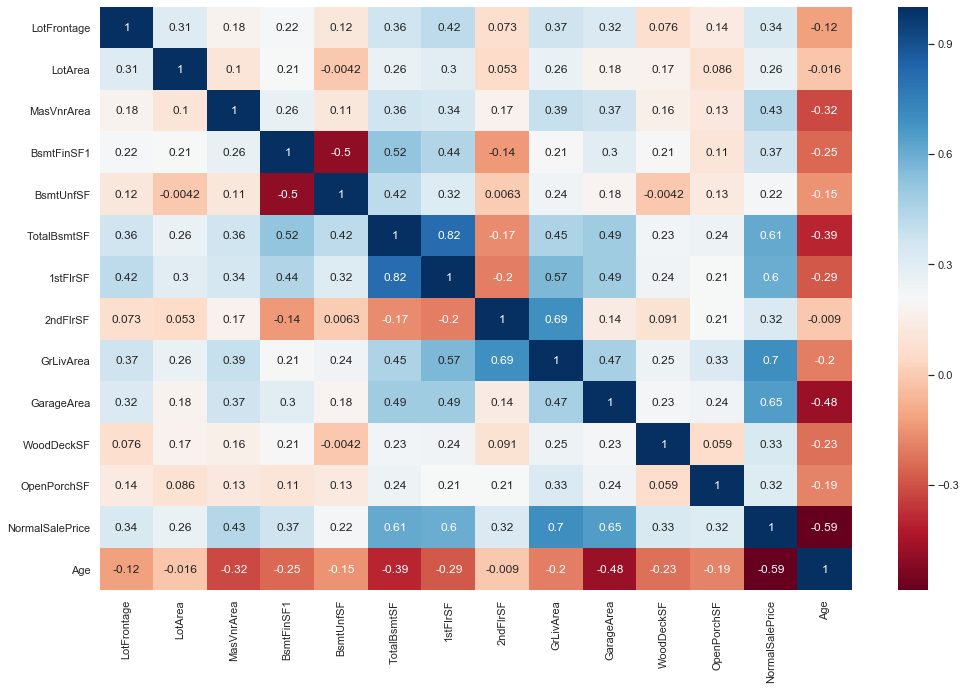

In [829]:
heat_map(housing_num)

We can see that following variables have correlation with `NormalSalePrice`
1. GarageArea
2. GrLivArea
3. TotalBsmtSF
4. 1stFlrSF
5. Age
6. MaxVnrArea

# Data preparation

We will introduce dummy variables followed by scaling the numerical variables

## Dummy Variable

In [830]:
columns_to_encode = housing.select_dtypes(include=['category', 'object'])
housing_model = housing
for c in columns_to_encode:
    housing_model = pd.get_dummies(housing_model,
                                   prefix=[c],
                                   columns=[c],
                                   drop_first=True)

In [831]:
housing_model.shape

(1382, 251)

## Splitting the Data into Training and Testing Sets

In [832]:
from sklearn.model_selection import train_test_split

np.random.seed(0)
housing_model_train, housing_model_test = train_test_split(housing_model,
                                                            train_size=0.7,
                                                            test_size=0.3,
                                                            random_state=100)

### Rescaling the Features

In [833]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

housing_model_train[num_vars] = scaler.fit_transform(
    housing_model_train[num_vars])

In [834]:

housing_model_train.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
840,0.4757,0.5313,0.0000,0.2075,0.1781,0.3211,0.2109,0.2376,0.2741,0.1923,...,0,0,0,0,1,0,0,0,1,0
1072,0.5534,0.5279,0.0000,0.1757,0.1836,0.3039,0.2405,0.3999,0.3868,0.3534,...,0,0,0,0,1,0,0,0,1,0
279,0.8350,0.6675,0.3055,0.0000,0.9080,0.8867,0.8683,0.0000,0.5657,0.5865,...,0,0,1,0,0,0,0,0,0,1
191,0.4757,0.4706,0.0000,0.1751,0.2380,0.3566,0.5904,0.6480,0.7575,0.3526,...,0,0,0,0,1,0,0,0,1,0
107,0.3786,0.4822,0.0000,0.0000,0.2744,0.2680,0.3465,0.0000,0.2257,0.2188,...,0,0,0,0,1,0,0,0,1,0


### Dividing into X and Y sets for the model building

In [835]:
y_train = housing_model_train.pop('NormalSalePrice')
X_train = housing_model_train

# Model Building and Evaluation

## Ridge Regression

In [836]:
params = {
    'alpha': [
        0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
        1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500,
        1000
    ]
}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator=ridge,
                        param_grid=params,
                        scoring='neg_mean_absolute_error',
                        cv=folds,
                        return_train_score=True,
                        verbose=1)
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [837]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha'] <= 200]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.0058,0.0019,0.0015,0.0006,0.0001,{'alpha': 0.0001},-0.0344,-0.0320,-0.0344,-0.0332,...,-0.0330,0.0014,24,-0.0200,-0.0205,-0.0196,-0.0200,-0.0205,-0.0201,0.0004
1,0.0036,0.0005,0.0010,0.0001,0.0010,{'alpha': 0.001},-0.0343,-0.0320,-0.0344,-0.0332,...,-0.0330,0.0014,23,-0.0200,-0.0205,-0.0196,-0.0200,-0.0205,-0.0201,0.0004
2,0.0030,0.0001,0.0009,0.0002,0.0100,{'alpha': 0.01},-0.0340,-0.0317,-0.0343,-0.0327,...,-0.0327,0.0013,22,-0.0200,-0.0205,-0.0196,-0.0200,-0.0205,-0.0201,0.0004
3,0.0029,0.0001,0.0008,0.0001,0.0500,{'alpha': 0.05},-0.0334,-0.0311,-0.0338,-0.0313,...,-0.0320,0.0014,20,-0.0200,-0.0206,-0.0197,-0.0202,-0.0206,-0.0202,0.0004
4,0.0029,0.0001,0.0008,0.0000,0.1000,{'alpha': 0.1},-0.0330,-0.0306,-0.0333,-0.0303,...,-0.0315,0.0014,19,-0.0201,-0.0207,-0.0198,-0.0203,-0.0206,-0.0203,0.0004


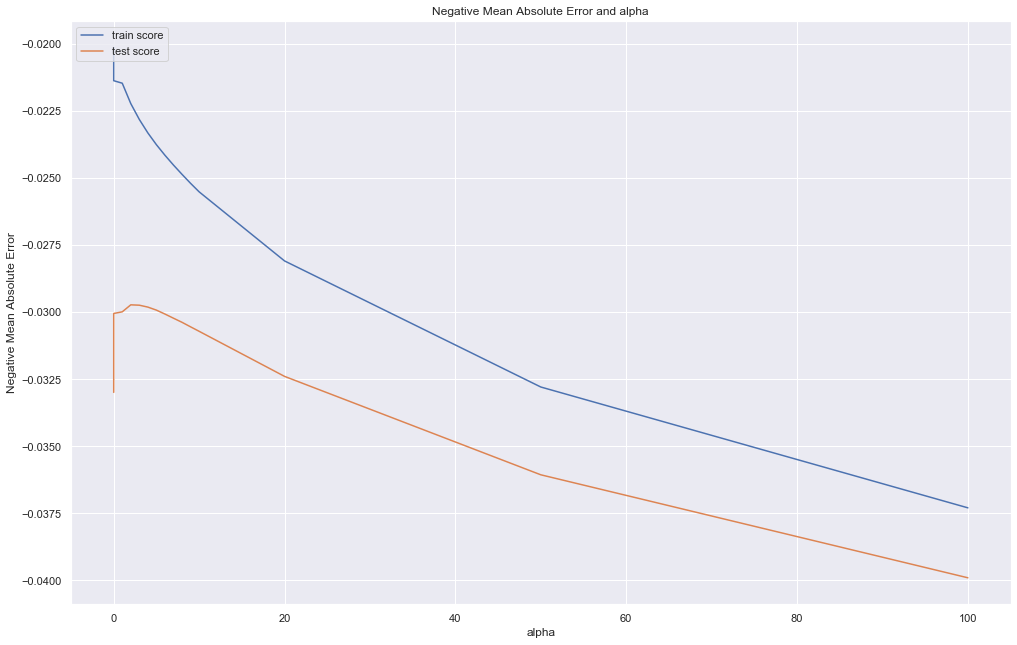

In [838]:
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [839]:
print('alpha: ',model_cv.best_params_['alpha'])
ridge = Ridge(alpha=model_cv.best_params_['alpha'])

ridge.fit(X_train, y_train)

alpha:  2.0


Ridge(alpha=2.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [840]:
# predict
y_train_pred = ridge.predict(X_train)
print(r2_score(y_true=y_train, y_pred=y_train_pred))

housing_model_test[num_vars] = scaler.transform(housing_model_test[num_vars])
y_test = housing_model_test['NormalSalePrice']
X_test = housing_model_test[housing_model_test.columns[~housing_model_test.columns.isin(['NormalSalePrice'])]]

y_test_pred = ridge.predict(X_test)
print(r2_score(y_true=y_test, y_pred=y_test_pred))



0.9505192075481103
0.8919358042045753


## Lasso 

In [841]:
#params = {'alpha': [0.0001, 0.005, 0.001, 0.01, 0.1, 1]}

lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator=lasso,
                        param_grid=params,
                        scoring='r2',
                        cv=folds,
                        return_train_score=True,
                        verbose=1)

model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

In [842]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.0314,0.0063,0.0016,0.0004,0.0001,{'alpha': 0.0001},0.9155,0.9187,0.9145,0.9122,...,0.9122,0.0064,1,0.9495,0.9498,0.9515,0.9514,0.9491,0.9503,0.0010
1,0.0156,0.0048,0.0014,0.0002,0.0010,{'alpha': 0.001},0.8783,0.8982,0.8758,0.8931,...,0.8721,0.0297,2,0.9013,0.8999,0.8988,0.9045,0.9005,0.9010,0.0019
2,0.0059,0.0005,0.0013,0.0004,0.0100,{'alpha': 0.01},0.5685,0.6623,0.5700,0.6280,...,0.5902,0.0492,3,0.6069,0.5807,0.6018,0.5983,0.6301,0.6036,0.0159
3,0.0035,0.0006,0.0010,0.0002,0.0500,{'alpha': 0.05},-0.0000,-0.0001,-0.0024,-0.0009,...,-0.0017,0.0019,4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0034,0.0007,0.0010,0.0001,0.1000,{'alpha': 0.1},-0.0000,-0.0001,-0.0024,-0.0009,...,-0.0017,0.0019,4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


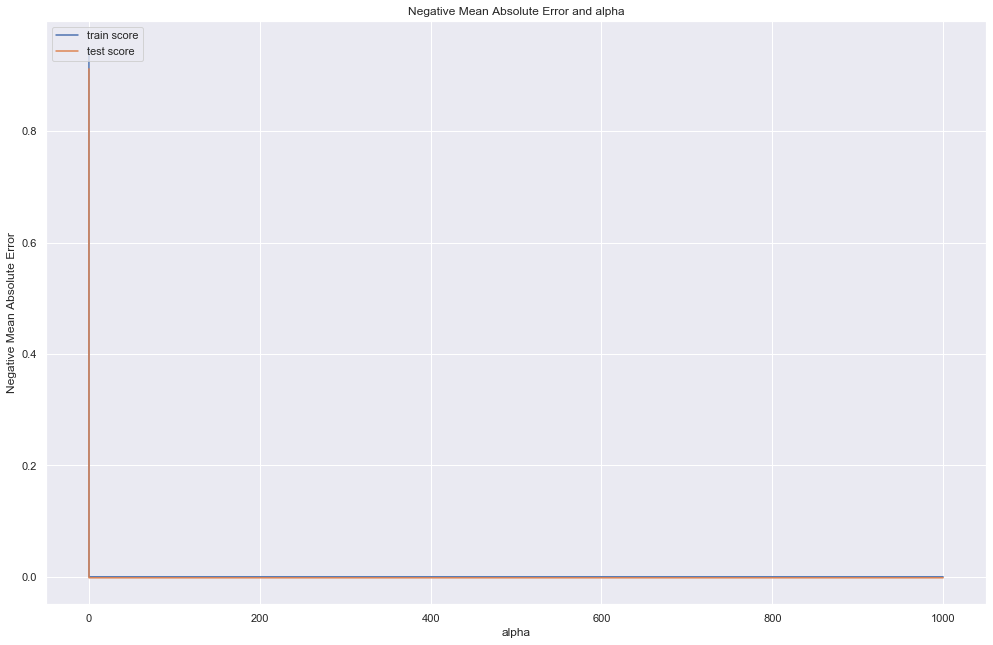

In [843]:
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [844]:
print('alpha: ',model_cv.best_params_['alpha'])
lasso = Lasso(alpha=model_cv.best_params_['alpha'])

lasso.fit(X_train, y_train)

alpha:  0.0001


Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [845]:
#Predict 
y_train_pred = lasso.predict(X_train)
print(r2_score(y_true=y_train, y_pred=y_train_pred))

y_test = housing_model_test['NormalSalePrice']
X_test = housing_model_test[housing_model_test.columns[~housing_model_test.columns.isin(['NormalSalePrice'])]]

y_test_pred = lasso.predict(X_test)
print(r2_score(y_true=y_test, y_pred=y_test_pred))

0.946583300823495
0.8931495750462322


In [846]:
list_of_tuples = list(zip(X_train.columns, lasso.coef_))
df_coef = pd.DataFrame(list_of_tuples, columns=['Column', 'Coef'])
df_coef = df_coef[df_coef['Coef'] != 0]

df_coef = df_coef.sort_values(by='Coef', ascending=False).reset_index()
df_coef.head(10)

,index,Column,Coef
0,8,GrLivArea,0.2830
1,5,TotalBsmtSF,0.1094
2,91,OverallQual_9,0.0626
3,28,MSZoning_RH,0.0546
4,92,OverallQual_10,0.0482
5,100,OverallCond_9,0.0481
6,9,GarageArea,0.0466
7,90,OverallQual_8,0.0431
8,46,Neighborhood_Crawfor,0.0426
9,1,LotArea,0.0420
